In [1]:
import pandas as pd
import numpy as np

from sklearn.cluster import HDBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score

from utils.db_engine import DBEngine
db = DBEngine()
engine = db.get_engine()

import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx

2025-04-17 07:25:34,278 - INFO - Database engine created successfully.


In [2]:
# --- Load Data from Database ---
query = """
SELECT listing_db_id, latitude, longitude
FROM rental_listings
WHERE
  state = 'DC'
  OR
  (state = 'WV' AND county = 'Jefferson')
  OR
  (state = 'MD' AND county IN ('Calvert', 'Charles', 'Frederick', 'Montgomery', 'Prince George''s')) -- Add single quote escape for Prince George's if needed
  OR
  (state = 'VA' AND (county IN ('Arlington', 'Clarke', 'Fairfax', 'Fauquier', 'Loudoun', 'Prince William', 'Spotsylvania', 'Stafford', 'Warren')
                     -- Assuming independent cities are stored in the 'county' or a similar field, adjust as needed:
                     OR city IN ('Alexandria', 'Fairfax', 'Falls Church', 'Fredericksburg', 'Manassas', 'Manassas Park')
                    )
  );
"""
source = pd.read_sql(query, engine)
# cols = ["listing_db_id", "latitude", "longitude"]
# df = source[cols]
df = source.copy()

In [3]:
df.head()

,listing_db_id,latitude,longitude
0,1,38.929782,-76.990611
1,2,38.957134,-77.027605
2,3,38.873441,-77.015450
3,4,38.907160,-77.082872
4,5,38.929726,-76.990505


In [4]:
# --- Define HDBSCAN Grid Search Function ---
def hdbscan_grid_search(
        dataframe,
        lat_col="latitude",
        lon_col="longitude",
        min_cluster_size_options=[5], 
        min_samples_options=[None],
        eval_metric="silhouette",
        metric="haversine",
):
    """
    Performs HDBSCAN grid search and returns results + best parameters
    """
    results = []
    df_processed = dataframe.copy()

    # Round close points to the same coordinates
    df_processed[lat_col] = df_processed[lat_col].round(4)
    df_processed[lon_col] = df_processed[lon_col].round(4)

    # Convert to numpy
    coords = df_processed[[lat_col, lon_col]].to_numpy()

    # Convert to radians
    coords_radians = np.radians(coords)
    
    total_points = len(coords_radians)
    
    if total_points == 0:
        print("Warning: No data points provided for grid search.")
        return pd.DataFrame(), None

    for min_cluster_size in min_cluster_size_options:
        if min_cluster_size <= 1 or min_cluster_size > total_points:
            print(f"Skipping invalid min_cluster_size: {min_cluster_size}")
            continue
            
        for min_samples in min_samples_options:
            current_min_samples = min_samples if min_samples is not None else min_cluster_size
            if current_min_samples <= 0 or current_min_samples > total_points:
                 print(f"Skipping invalid min_samples={current_min_samples}")
                 continue
            # Create and fit the HDBSCAN clusterer
            hdbscan = HDBSCAN(
                min_cluster_size=min_cluster_size,
                min_samples=min_samples,
                metric=metric,
                n_jobs=-1
            )
            labels = hdbscan.fit_predict(coords_radians)
            
            # Count clusters and noise (ignoring label -1 which stands for noise)
            n_clusters = len(np.unique(labels)) - (1 if -1 in labels else 0)
            noise_points = np.sum(labels == -1)
            fraction_noise = noise_points / total_points if total_points > 0 else 0
            
            sil_score = np.nan
            clustered_mask = (labels != -1)
            n_clustered_points = np.sum(clustered_mask)

            # Compute silhouette score only if more than 1 cluster and at least some valid points exist.
            if n_clusters > 1 and n_clustered_points >= (n_clusters + 1):
                try:
                    sil_score = silhouette_score(
                        coords_radians[clustered_mask], 
                        labels[clustered_mask], 
                        metric=metric)
                except ValueError as e:
                    print(f"Silhouette error for mcs={min_cluster_size}, ms={min_samples}: {e}")
                    sil_score = np.nan
            elif n_clusters <= 1:
                print(f"Skipping silhouette: n_clusters={n_clusters}")
                pass
            
            results.append({
                "min_cluster_size": min_cluster_size,
                "min_samples": min_samples,
                "n_clusters": n_clusters,
                "noise_fraction": fraction_noise,
                "silhouette": sil_score
            })
            
            results_df = pd.DataFrame(results)

            # Find best parameters
            best_params = None
            if not results_df.empty:
                # Filter out rows where the metric calculation failed (NaN) if optimizing that metric
                if eval_metric == "silhouette":
                     valid_results = results_df.dropna(subset=["silhouette"])
                     if not valid_results.empty:
                          best_idx = valid_results["silhouette"].astype(float).idxmax()
                          best_params = results_df.loc[best_idx].to_dict()
                elif eval_metric == "noise_fraction":
                     # For noise fraction, NaN is not expected unless HDBSCAN fails entirely
                     valid_results = results_df
                     if not valid_results.empty:
                          best_idx = valid_results["noise_fraction"].astype(float).idxmin()
                          best_params = results_df.loc[best_idx].to_dict()
                        
                if best_params:
                     # Convert back to int where needed
                     best_params['min_cluster_size'] = int(best_params['min_cluster_size'])
                     if best_params['min_samples'] is not None and pd.notna(best_params['min_samples']):
                         best_params['min_samples'] = int(best_params['min_samples'])
                     else:
                         best_params['min_samples'] = None

    return results_df, best_params


# --- Perform HDBSCAN Grid Search (First Round) ---
# Define parameter ranges to explore:
first_round_size_options = [5, 10, 15, 20]
first_round_samples_options = [None, 5, 10]


first_round_df = df.copy()
first_round_result, first_round_best_params = hdbscan_grid_search(
    dataframe=first_round_df,
    lat_col="latitude",
    lon_col="longitude",
    min_cluster_size_options=first_round_size_options,
    min_samples_options=first_round_samples_options,
    eval_metric="silhouette",
    metric="haversine"
)
print("First round results:")
print(first_round_result)
print("Best parameters from first round:")
print(first_round_best_params)


First round results:
    min_cluster_size  min_samples  n_clusters  noise_fraction  silhouette
0                  5          NaN         710        0.159359    0.858809
1                  5          5.0         710        0.159359    0.858809
2                  5         10.0         434        0.226651    0.849484
3                 10          NaN         398        0.226260    0.838088
4                 10          5.0         438        0.169050    0.793404
5                 10         10.0         398        0.226260    0.838088
6                 15          NaN         284        0.271200    0.828505
7                 15          5.0         319        0.189293    0.747283
8                 15         10.0         291        0.237827    0.791804
9                 20          NaN         218        0.315201    0.816403
10                20          5.0         253        0.207581    0.721946
11                20         10.0         237        0.247050    0.757096
Best parameters f

In [5]:
# --- Perform HDBSCAN with the best parameters (First Round) ---
first_round_df = df.copy()


# first_hdbscan = HDBSCAN(
#     min_cluster_size=5,
#     min_samples=10,
#     metric="haversine"
# )

first_hdbscan = HDBSCAN(
    min_cluster_size=5,
    min_samples=5,
    metric="haversine",
    n_jobs=-1
)

first_round_df["latitude"] = first_round_df["latitude"].round(4)
first_round_df["longitude"] = first_round_df["longitude"].round(4)
first_coordinates_radians = np.radians(first_round_df[["latitude", "longitude"]].to_numpy())

# Fit the HDBSCAN model
first_round_labels = first_hdbscan.fit_predict(first_coordinates_radians)

first_round_df.loc[:, "cluster"] = first_round_labels
# Check how many clusters were found (noise points are labeled -1)
num_clusters = len(np.unique(first_round_labels)) - (1 if -1 in first_round_labels else 0)
print(f"Number of clusters found: {num_clusters}")


Number of clusters found: 710


In [6]:
first_round_df.head()

,listing_db_id,latitude,longitude,cluster
0,1,38.9298,-76.9906,-1
1,2,38.9571,-77.0276,570
2,3,38.8734,-77.0154,546
3,4,38.9072,-77.0829,393
4,5,38.9297,-76.9905,-1


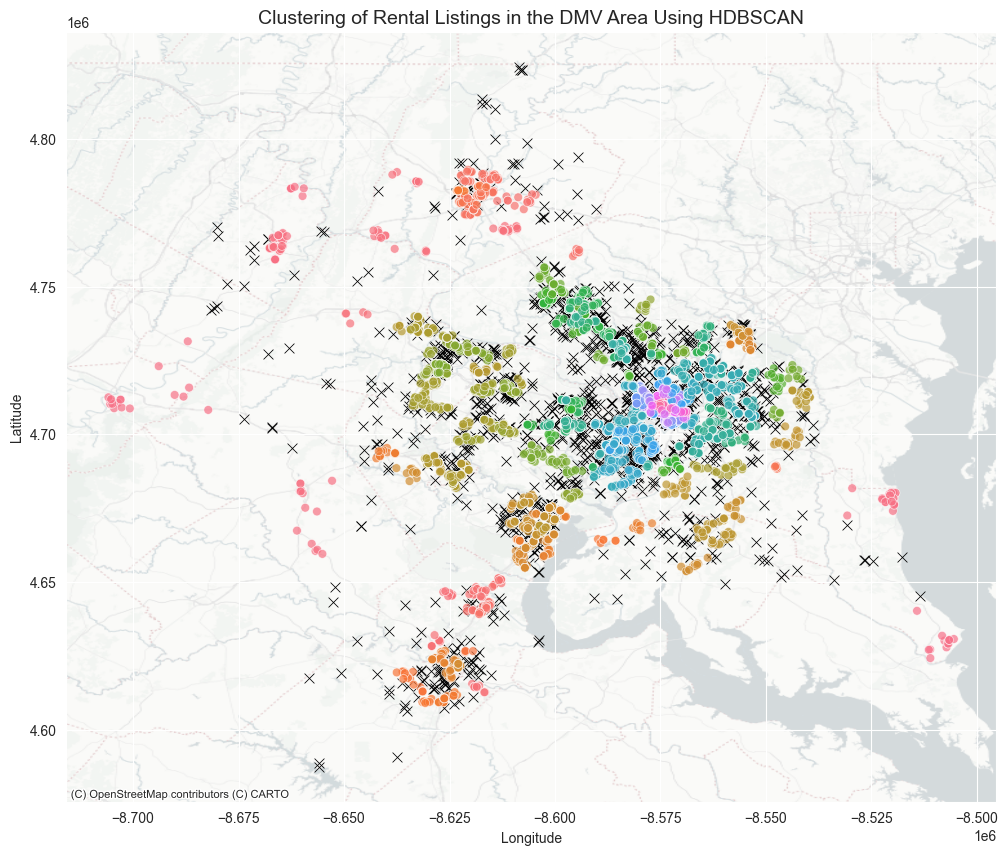

In [7]:
# Convert df to GeoDataFrame and plot clusters
def plot_clusters(input_df):
    gdf = gpd.GeoDataFrame(
        input_df, 
        geometry=gpd.points_from_xy(input_df.longitude, input_df.latitude),
        crs="EPSG:4326"
    )

    # Project to Web Mercator for basemap compatibility
    gdf = gdf.to_crs(epsg=3857)
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(12, 10))
    
    unique_labels = np.unique(gdf["cluster"])
    n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)  # Exclude noise if present
    palette = sns.color_palette("husl", n_colors=n_clusters)
    
    # Create a new color column for plotting
    gdf["point_color"] = gdf["cluster"].apply(lambda x: "black" if x == -1 else palette[x])
    
    # Plot noise points separately if they exist
    if -1 in unique_labels:
        noise_mask = gdf["cluster"] == -1
        sns.scatterplot(
            x=gdf.loc[noise_mask, "geometry"].x,
            y=gdf.loc[noise_mask, "geometry"].y,
            color="black",
            marker="x",
            s=50,
            label="Noise",
            ax=ax
        )
    
    # Plot clusters (excluding noise)
    cluster_mask = gdf["cluster"] != -1
    sns.scatterplot(
        x=gdf.loc[cluster_mask, "geometry"].x,
        y=gdf.loc[cluster_mask, "geometry"].y,
        hue=gdf.loc[cluster_mask, "cluster"],
        palette=palette,
        marker="o",
        s=40,
        alpha=0.7,
        ax=ax,
        legend="brief"
    )
    
    # Set limits based on data bounds
    xmin, ymin, xmax, ymax = gdf.total_bounds
    
    # Add padding (5% on each side)
    padding_x = (xmax - xmin) * 0.05
    padding_y = (ymax - ymin) * 0.05
    
    # Set expanded limits
    ax.set_xlim(xmin - padding_x, xmax + padding_x)
    ax.set_ylim(ymin - padding_y, ymax + padding_y)
    
    # Add basemap
    basemap_source = ctx.providers.CartoDB.PositronNoLabels
    
    ctx.add_basemap(ax, source=basemap_source)
    
    # Add titles and labels
    ax.set_title("Clustering of Rental Listings in the DMV Area Using HDBSCAN", fontsize=14)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.get_legend().remove()
    ax.grid(True)
    plt.show()
    
    
plot_clusters(first_round_df)

In [8]:
# Identify noise points and their indices
noise_mask = first_round_df["cluster"] == -1
noise_indices = first_round_df.index[noise_mask]

# Create noise dataframe for second round HDBSCAN
second_round_df = first_round_df.loc[noise_indices].copy()

In [9]:
# --- Perform HDBSCAN with the best parameters (Second Round) ---

second_round_size_options = [2, 3, 5, 7, 10]
second_round_samples_options = [None, 2, 3, 5]

second_round_result, second_round_best_params = hdbscan_grid_search(
    dataframe=second_round_df,
    lat_col="latitude",
    lon_col="longitude",
    min_cluster_size_options=second_round_size_options,
    min_samples_options=second_round_samples_options,
    eval_metric="noise_fraction",
    metric="haversine"
)
print("Second round results:")
print(second_round_result)
print("Best parameters from Second round:")
print(second_round_best_params)

Second round results:
    min_cluster_size  min_samples  n_clusters  noise_fraction  silhouette
0                  2          NaN         619        0.126042    0.626447
1                  2          2.0         619        0.126042    0.626447
2                  2          3.0         356        0.232957    0.583495
3                  2          5.0         159        0.321726    0.516343
4                  3          NaN         320        0.236390    0.585412
5                  3          2.0         365        0.178519    0.555398
6                  3          3.0         320        0.236390    0.585412
7                  3          5.0         118        0.300638    0.528495
8                  5          NaN         105        0.305542    0.521324
9                  5          2.0         153        0.168220    0.466339
10                 5          3.0         137        0.198136    0.478292
11                 5          5.0         105        0.305542    0.521324
12              

/var/folders/66/1q8bft0j43j9_rs20_lp5zj80000gn/T/ipykernel_48384/2385800619.py:37: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


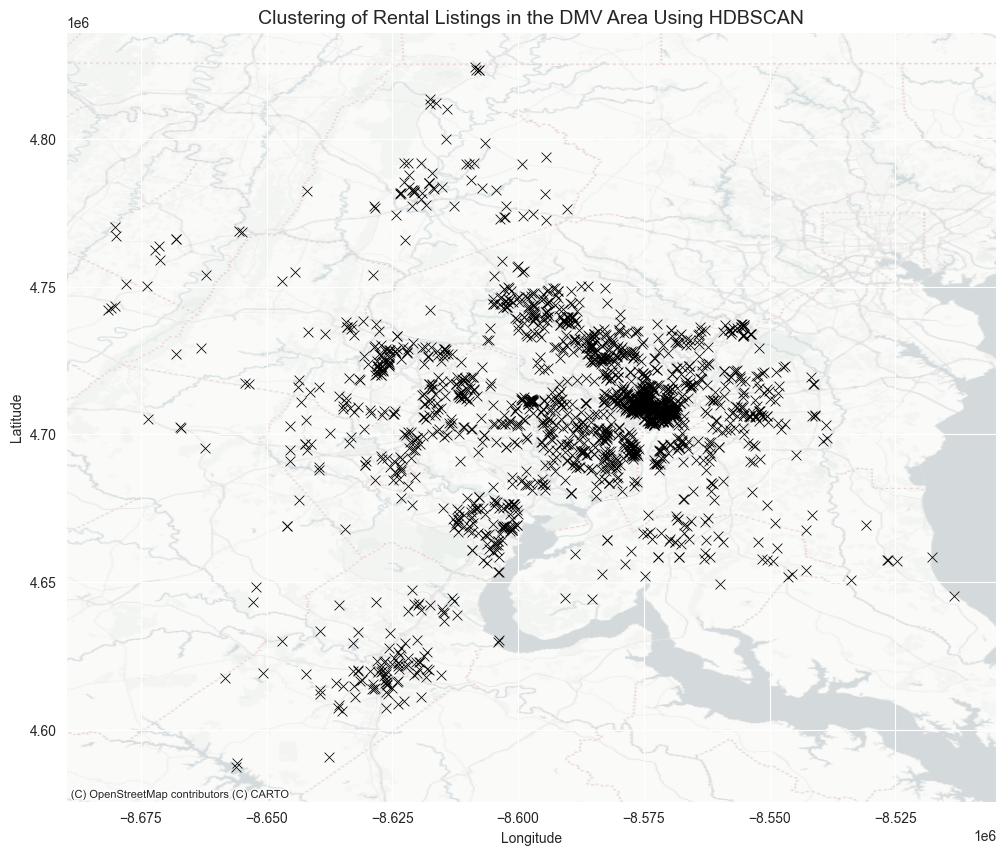

In [10]:
plot_clusters(second_round_df)

In [11]:
# --- Run second run HDBSCAN with best params ---
noise_coordinates_radians = np.radians(second_round_df[["latitude", "longitude"]].to_numpy())
second_hdbscan = HDBSCAN(
    min_cluster_size=2,
    min_samples=2,
    metric="haversine",
    n_jobs=-1
)

secondary_labels = second_hdbscan.fit_predict(noise_coordinates_radians)

In [12]:
# Compute max id for the first round
max_cluster_id_first = first_round_df.loc[~noise_mask, "cluster"].max()

# Generate new labels for the second round
new_noise_labels = np.where(secondary_labels >= 0, max_cluster_id_first + 1 + secondary_labels, -1)

# Create the final dataframe
final_df = first_round_df.copy()
final_df.loc[noise_mask, "cluster"] = new_noise_labels
remaining_noise_count = np.sum(secondary_labels == -1)
print(f"Secondary clustering done. {remaining_noise_count} points remain as remaining noise.")


Secondary clustering done. 257 points remain as remaining noise.


In [13]:
# --- Assigning Remaining Noise to Nearest Centroid ---
remaining_noise_mask = final_df["cluster"] == -1
remaining_noise_indices = final_df.index[remaining_noise_mask]
remaining_coords_radians = np.radians(final_df.loc[remaining_noise_indices, ["latitude", "longitude"]].to_numpy())

# Get the cluster centroids
clustered_points = final_df.loc[~remaining_noise_mask]
all_centroids_df = clustered_points.groupby("cluster")[["latitude", "longitude"]].mean()
all_centroid_coords_radians = np.radians(all_centroids_df.to_numpy())
all_centroid_ids = all_centroids_df.index.to_numpy()

# Compute distances to centroids
from sklearn.metrics.pairwise import haversine_distances
distances = haversine_distances(remaining_coords_radians, all_centroid_coords_radians)
nearest_centroid_indices = np.argmin(distances, axis=1)
nearest_cluster_ids = all_centroid_ids[nearest_centroid_indices]

# Assign the nearest cluster ID to the remaining noise points
final_df.loc[remaining_noise_indices, "cluster"] = nearest_cluster_ids

In [14]:
final_df.head()

,listing_db_id,latitude,longitude,cluster
0,1,38.9298,-76.9906,1181
1,2,38.9571,-77.0276,570
2,3,38.8734,-77.0154,546
3,4,38.9072,-77.0829,393
4,5,38.9297,-76.9905,1181


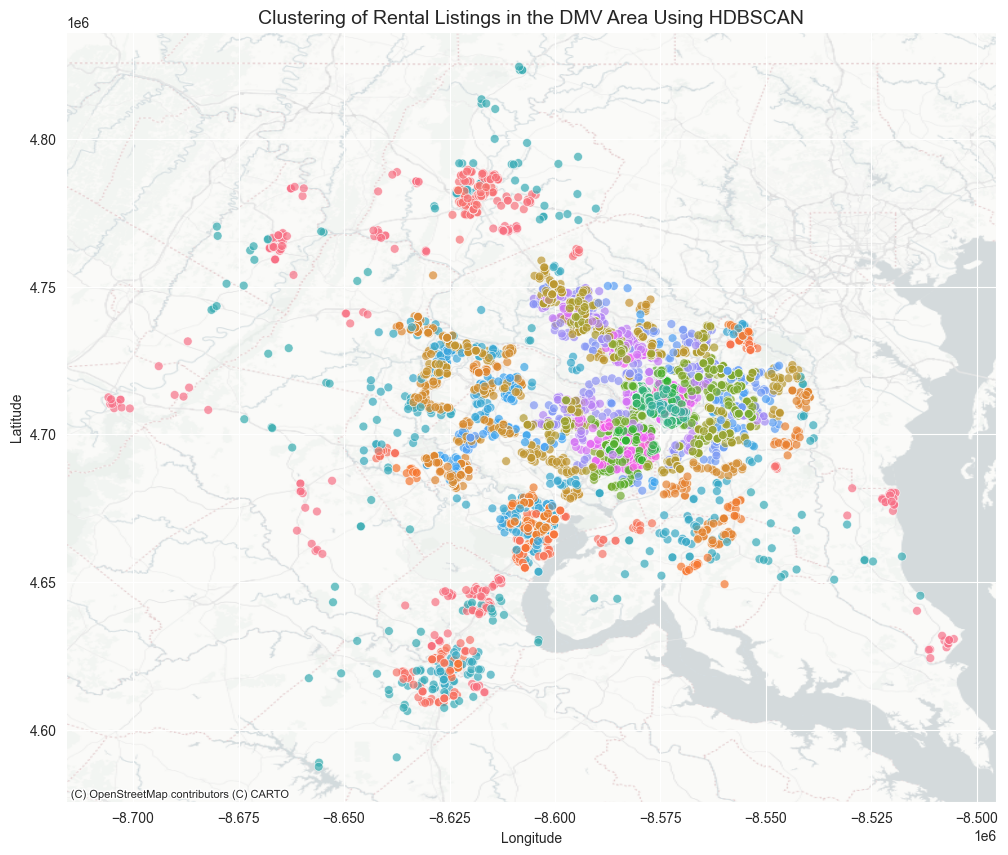

In [15]:
# --- Final Clustering Results ---
plot_clusters(final_df)

In [16]:
final_df.to_csv("final_clustering_results.csv", index=False)

In [17]:
all_centroids_df.head()

,latitude,longitude
cluster,,
0,38.356777,-76.432738
1,38.940024,-78.138924
2,39.425867,-77.807317
3,38.696919,-76.546689
4,39.261880,-77.851000


In [18]:
temp = final_df.groupby("cluster")[["listing_db_id"]].count()
new_all_centroids_df = pd.merge(all_centroids_df, temp, left_index=True, right_index=True).rename(columns={"listing_db_id": "member_count"})

new_all_centroids_df.head()

,latitude,longitude,member_count
cluster,,,
0,38.356777,-76.432738,13
1,38.940024,-78.138924,17
2,39.425867,-77.807317,6
3,38.696919,-76.546689,27
4,39.261880,-77.851000,6


In [19]:
new_all_centroids_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1329 entries, 0 to 1328
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   latitude      1329 non-null   float64
 1   longitude     1329 non-null   float64
 2   member_count  1329 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 41.5 KB


In [20]:
new_all_centroids_df.reset_index(inplace=True)
new_all_centroids_df.rename(columns={"cluster": "cluster_id", "latitude": "centroid_lat", "longitude": "centroid_lon"}, inplace=True)
new_all_centroids_df.loc[:, "cluster_id"] = new_all_centroids_df["cluster_id"].astype(int) + 1
new_all_centroids_df.head()

,cluster_id,centroid_lat,centroid_lon,member_count
0,1,38.356777,-76.432738,13
1,2,38.940024,-78.138924,17
2,3,39.425867,-77.807317,6
3,4,38.696919,-76.546689,27
4,5,39.261880,-77.851000,6


In [21]:
new_all_centroids_df.to_sql(
    name="rental_clusters",
    con=engine,
    if_exists="append",
    index=False
)

329

In [22]:
new_all_centroids_df.head()

,cluster_id,centroid_lat,centroid_lon,member_count
0,1,38.356777,-76.432738,13
1,2,38.940024,-78.138924,17
2,3,39.425867,-77.807317,6
3,4,38.696919,-76.546689,27
4,5,39.261880,-77.851000,6


In [23]:
# --- Save the final clustering results to the database ---
to_db_final = final_df.copy()
to_db_final.reset_index(inplace=True)
to_db_final.drop(columns=["latitude", "longitude"], inplace=True)
to_db_final.rename(columns={"cluster": "cluster_id", "index": "assignment_id"}, inplace=True)
to_db_final.loc[:, "assignment_id"] = to_db_final["assignment_id"].astype(int) + 1 
to_db_final.loc[:, "cluster_id"] = to_db_final["cluster_id"].astype(int) + 1 


In [24]:
to_db_final.head()

,assignment_id,listing_db_id,cluster_id
0,1,1,1182
1,2,2,571
2,3,3,547
3,4,4,394
4,5,5,1182


In [25]:
to_db_final.to_sql(
    name="listing_clusters",
    con=engine,
    if_exists="append",
    index=False
)

795

In [26]:
to_db_final.head(10)

,assignment_id,listing_db_id,cluster_id
0,1,1,1182
1,2,2,571
2,3,3,547
3,4,4,394
4,5,5,1182
5,6,6,642
6,7,7,620
7,8,8,521
8,9,9,1287
9,10,10,564
